# Fake and Real News Detection Model

## Fetch Dataset

In [14]:
# import kagglehub
# clmentbisaillon_fake_and_real_news_dataset_path = kagglehub.dataset_download('clmentbisaillon/fake-and-real-news-dataset')

# print('Data source import complete.')

## Install Dependencies

In [15]:
# !pip install pandas
# !pip install numpy
# !pip install tensorflow
# !pip install scikit-learn

## Imports

In [16]:
import pandas as pd
import numpy as np
import re
import pickle
from tqdm.auto import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Loading Dataset

In [17]:
print("🔄 Loading dataset...")

FAKE_PATH = "./kaggle/input/fake-and-real-news-dataset/Fake.csv"
TRUE_PATH = "./kaggle/input/fake-and-real-news-dataset/True.csv"

fake_df = pd.read_csv(FAKE_PATH)
true_df = pd.read_csv(TRUE_PATH)

print("✔ Loaded successfully!")
print("Fake shape:", fake_df.shape)
print("True shape:", true_df.shape)

🔄 Loading dataset...
✔ Loaded successfully!
Fake shape: (23481, 4)
True shape: (21417, 4)


## Assigning Labels

In [18]:
print("\n🔄 Assigning labels (0 = Fake, 1 = True)...")

fake_df["label"] = 0
true_df["label"] = 1

df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

print("✔ Dataset combined. Total records:", df.shape[0])


🔄 Assigning labels (0 = Fake, 1 = True)...
✔ Dataset combined. Total records: 44898


## 3. Cleaning Text

In [19]:
print("\nCleaning text... (this may take time)")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)            # Punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = df["text"].progress_apply(clean_text)

print("Text cleaning completed.")


Cleaning text... (this may take time)


100%|██████████| 44898/44898 [00:17<00:00, 2571.64it/s]

Text cleaning completed.


## 4. Splitting Data

In [20]:
print("\nSplitting data into train/test sets...")

X = df["clean_text"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✔ Data split complete.")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Splitting data into train/test sets...
✔ Data split complete.
Training samples: 35918
Testing samples: 8980


## 5. Tokenization

In [21]:
print("\nTokenizing and converting to sequences...")

vocab_size = 20000
max_length = 300

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(tqdm(X_train))

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

print("Tokenization complete. Vocabulary size:", len(tokenizer.word_index))


Tokenizing and converting to sequences...


100%|██████████| 35918/35918 [00:17<00:00, 2015.12it/s]


Tokenization complete. Vocabulary size: 187319


## 6. Save Tokkenizer

In [22]:
print("\nSaving tokenizer...")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("okenizer saved as tokenizer.pkl")


Saving tokenizer...
okenizer saved as tokenizer.pkl


## 7. Building CNN Model

In [ ]:
print("\nBuilding CNN model...")

model = Sequential([
    Embedding(vocab_size, 128),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()
print("CNN model built.")


Building CNN model...


/home/meher/dev/projects/fake-news-detection/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-12-10 07:21:02.147317: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

CNN model built.


## 8. Training

In [24]:
print("\nTraining CNN model... (this WILL take several minutes)")

history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

print("Model training complete.")


Training CNN model... (this WILL take several minutes)


Epoch 1/5


2025-12-10 07:21:02.471036: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 38791200 exceeds 10% of free system memory.


253/253 ━━━━━━━━━━━━━━━━━━━━ 104s 397ms/step - accuracy: 0.9461 - loss: 0.1462 - val_accuracy: 0.9916 - val_loss: 0.0266
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 141s 395ms/step - accuracy: 0.9957 - loss: 0.0151 - val_accuracy: 0.9953 - val_loss: 0.0160
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 86s 340ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9944 - val_loss: 0.0186
Epoch 4/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 86s 340ms/step - accuracy: 0.9999 - loss: 8.5742e-04 - val_accuracy: 0.9955 - val_loss: 0.0149
Epoch 5/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 60s 238ms/step - accuracy: 1.0000 - loss: 4.9627e-04 - val_accuracy: 0.9958 - val_loss: 0.0151
Model training complete.


## 9. Evaluation

In [25]:
print("\nEvaluating model...")

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Evaluating model...
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Accuracy: 0.9933184855233853

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## 10. Confusion Matrix


Generating Confusion Matrix...


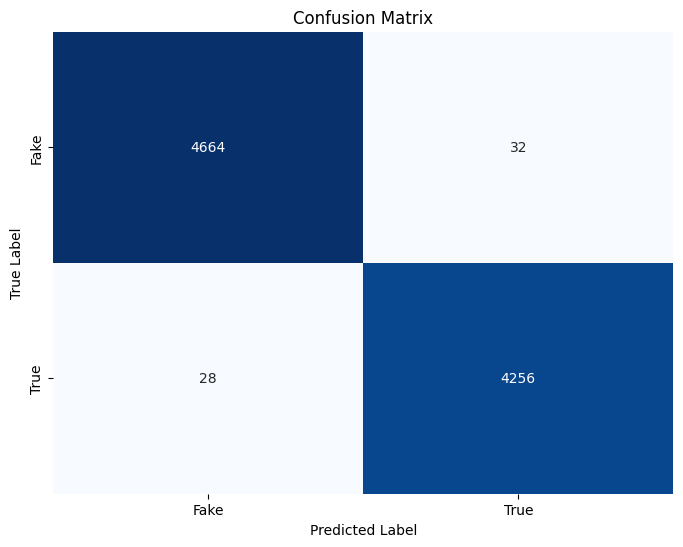


Confusion Matrix generated.


In [26]:
print("\nGenerating Confusion Matrix...")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix generated.")

## 11. Save Model

In [27]:
print("\nSaving model...")

model.save("fake_news_cnn.keras")

print("Model saved as fake_news_cnn.h5")
print("\nALL DONE — CNN model is ready for deployment!")


Saving model...
Model saved as fake_news_cnn.h5

ALL DONE — CNN model is ready for deployment!


In [32]:
!mv ./tokenizer.pkl ../ml_backend/
!mv ./fake_news_cnn.keras ../ml_backend/

mv: cannot stat './tokenizer.pkl': No such file or directory
